In [1]:
import os
import json
import math
from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision.transforms import Resize, InterpolationMode

from attribution import permutation_generator, aggregate_interactions
from utils import vis_top_attr, vis_bottom_attr


# Device Setting

In [2]:
device = torch.device('cuda')

# Load Model & Data

In [3]:
# from torchvision import models, transforms
# model = models.vgg19(pretrained=True)
# model.eval();

''

In [28]:
with open('./data/label_name.json') as json_file:
    label_name = json.load(json_file)
    
# ImageNet normalize params
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize_transform = transforms.Normalize(mean=mean, std=std)
base = np.zeros(3)

In [25]:
img_path = './data/image0.png'

patch_size = [20, 20] # 20x20 patches
n_samples = 100 # num permutations
b_size = 60 # batch size

387 red panda


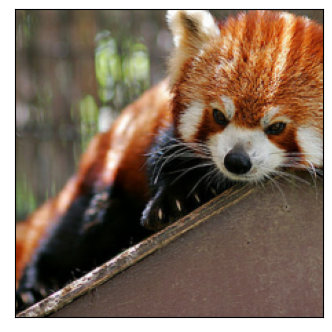

In [30]:
img = Image.open(img_path)
transform = transforms.ToTensor()
x = transform(img)
x = normalize_transform(x)
img_size = x.shape[2:]

y_pred = torch.argmax(model(x.to(device).unsqueeze(0))).item()
print(y_pred, label_name[y_pred])

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.xticks([]); plt.yticks([]); 
plt.show();

# Aggregate Interactions

In [31]:
N = patch_size[0]*patch_size[1]
resize = Resize(img_size, interpolation=InterpolationMode.NEAREST)

# Generate patch masks
patch_masks = []
for j in range(N):
    mask = np.zeros(N)
    mask[j] = 1
    mask = resize(torch.Tensor(mask).reshape(-1,patch_size[0], patch_size[1])).unsqueeze(1)
    patch_masks.append(mask.numpy())
patch_masks = np.array(patch_masks).squeeze()

pi_generator = permutation_generator(N, n_samples)


In [32]:
shapley_attr, api_attr = aggregate_interactions(model, x, y_pred, b_size, patch_size, 
                                      patch_masks, pi_generator, device, base=base)

30it [02:46,  5.56s/it]


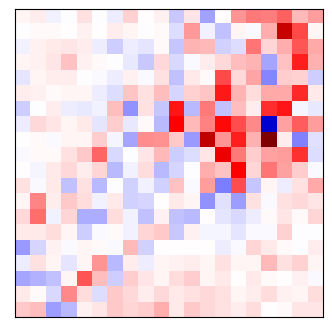

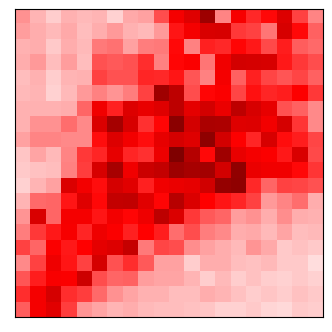

In [33]:
cmax = max(np.max(shapley_attr), -np.min(shapley_attr))
plt.figure(figsize=(4,4))
plt.imshow(shapley_attr.reshape((patch_size[0],patch_size[1])), cmap='seismic', vmax=cmax, vmin=-cmax)
plt.xticks([])
plt.yticks([])
plt.show()

cmax = max(np.max(api_attr), -np.min(api_attr)) 
plt.figure(figsize=(4,4))
plt.imshow(api_attr.reshape((patch_size[0],patch_size[1])), cmap='seismic', vmax=cmax, vmin=-cmax)
plt.xticks([])
plt.yticks([])
plt.show()

Shapley value - Top features


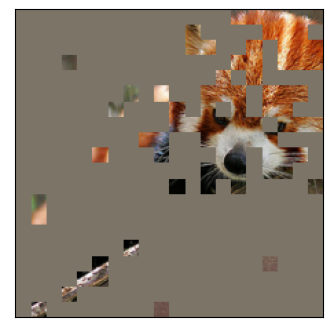

API - Top features


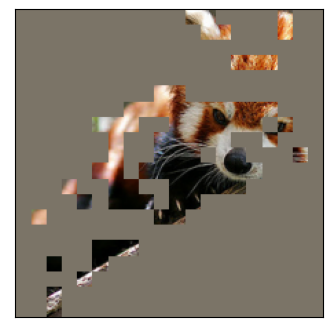

Shapley value - Bottom features


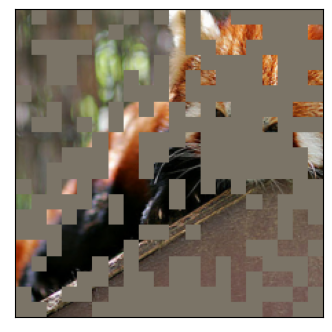

API - Bottom features


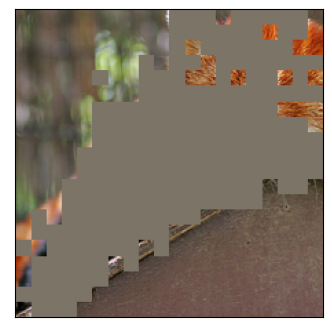

In [34]:
print("Shapley value - Top features")
vis_top_attr(img, shapley_attr, patch_size, base=mean)
print("API - Top features")
vis_top_attr(img, api_attr, patch_size, base=mean)

print("Shapley value - Bottom features")
vis_bottom_attr(img, shapley_attr, patch_size, base=mean)
print("API - Bottom features")
vis_bottom_attr(img, api_attr, patch_size, base=mean)